## Data preparation and preprocessing

### Short introduction

We are the Conloquor team, which means dialogue in latin. We will be developing a chatbot for our project this semester.

Members:

- Béres Bálint
- Drexler Konrád
- Drexler Kristóf

### Data source

We found a dataset on [reddit](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)
which includes all the reddit comments categorized by month. A user uploaded the entire dataset to google's
bigquery platform, here's the [reddit](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/)
thread.

### Downloading the data

We chose to use comments from may, 2015 for our project. For this we ran the following SQL query on the bigquery platform.

```SQL
select *
from `fh-bigquery.reddit_comments.2015_05`
where subreddit like 'science'
    or subreddit like 'politics'
    or subreddit like 'gaming'
    or subreddit like 'worldnews'
    or subreddit like 'CasualConversation'
    or subreddit like 'sports'
```

At first we downloaded all the comments made that month, but the resulting file was 5GB compressed.
Therefore, we limited the source subreddits to **r/science**, **r/politics**, **r/gaming**,
**r/worldnews**, **r/CasualConversation** and **r/sports**. This query still yielded 1.45 million
comments to work with, but was a manageable size. We exported the resulting table to a json file;
 `data_2015_05.json`. This `.json` is available on my [google drive](https://drive.google.com/file/d/13n1ET0mppD6i-DjqyJIFjAiMQp6V7v6q/view?usp=sharing).
 In the future, the project will automatically download the data.

## Formatting the data for preprocessing

The initial json file still had a lot of unnecessary columns and unusable rows. Using further SQL queries we
trimmed and transformed the data to fit our needs. At the end of the process we were left with just short of
480000 message-response pairs. This was done by by filtering out messages longer than 200 characters, [deleted] messages
and hyperlink only messages to name a few.

In [ ]:
# pandasql is not in the google colab repertoir by default, it needs to be installed manually
!pip install pandasql

In [ ]:
# import statements
import pandas as pd
import pandasql as ps

In [ ]:
# Create dataframe from json file
raw_data_df = pd.read_json(r'data_2015_05.json', orient='records', lines=True)

In [ ]:
# Show top ten rows
raw_data_df.head(10)

,body,score_hidden,archived,name,author,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,author_flair_text,author_flair_css_class,distinguished
0,That wasn't just a personal belief of his. It'...,False,False,t1_cr7h0ln,tejon,0,1431494075,t5_2cneq,t3_35ql9d,t1_cr7fnj4,136,1433034878,0,0,cr7h0ln,politics,136,NaN,NaN,NaN
1,I think you're on to something there. But to b...,False,False,t1_crpxkmu,Tangpo,0,1432999141,t5_2cneq,t3_37tyhm,t1_crpw8y8,17,1433393342,0,0,crpxkmu,politics,17,NaN,NaN,NaN
2,They've also been rather clear on defining a f...,False,False,t1_cr43h2c,Qu1nlan,0,1431220695,t5_2cneq,t3_35eepj,t1_cr439ea,19,1432870611,0,0,cr43h2c,politics,19,NaN,NaN,NaN
3,God bless you.,False,False,t1_cr5rn0g,broncoz33,0,1431370502,t5_2qh03,t3_35liga,t1_cr5qa14,13,1432899458,0,0,cr5rn0g,gaming,13,NaN,NaN,NaN
4,Western corporations don't give a rats arse to...,False,False,t1_cra1d35,critfist,0,1431701414,t5_2qh13,t3_361cco,t1_cra0qd0,-4,1433079241,0,0,cra1d35,worldnews,-4,NaN,NaN,NaN
5,[deleted],False,False,t1_cqvze0l,[deleted],0,1430571181,t5_2qh13,t3_34lnbr,t1_cqvye5y,-3,1432729493,0,0,cqvze0l,worldnews,-3,NaN,NaN,NaN
6,http://en.wikipedia.org/wiki/Celebration_Cruis...,False,False,t1_crqsdm6,Atheist101,0,1433078136,t5_323oy,t3_37v2sr,t1_crqdes4,-4,1433496812,0,0,crqsdm6,CasualConversation,-4,NaN,NaN,NaN
7,"I'm not attacking them, I'm making an observat...",False,False,t1_crahjf8,utb040713,0,1431728711,t5_mouw,t3_3622fk,t1_cragizb,0,1433087005,0,0,crahjf8,science,0,NaN,NaN,NaN
8,"Well, that's a vile and disgusting thing to sa...",False,False,t1_cr4qp74,Fractal_Soul,0,1431286132,t5_2cneq,t3_35ffem,t1_cr4div8,0,1432881767,0,0,cr4qp74,politics,0,NaN,NaN,NaN
9,Are you 15? Lol,False,False,t1_crcbtar,chuchubaba,0,1431900496,t5_2qh03,t3_369dwg,t1_crc88ht,0,1433118815,0,0,crcbtar,gaming,0,NaN,NaN,NaN


In [ ]:
# Filter raw data:
# select only rows which have a length less than 200, and the comment wasn't [deleted]
sql_query = " select body" \
            "       , name" \
            "       , link_id" \
            "       , parent_id" \
            "       , score" \
            " from raw_data_df" \
            " where length(body) < 200 and body <> '[deleted]'"
# Can only be saved as sdf since this is how pandas works.
sdf = ps.sqldf(sql_query)

In [ ]:
# Delete the original Dataframe to save memory
del raw_data_df

In [ ]:
# List of regular expressions to further filter the bodies of the comments;

# Remove all links from the comments
sdf.replace(r'https?://(www.)?[-a-zA-Z0-9@:%.+~#=]{1,256}.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9(_)@:%+.~#?&//=]*)','',regex=True, inplace = True)

# Remove all user links/subreddit links
sdf.replace(r'(/u/)?(r/)?(^)?(\\)?','',regex=True, inplace = True)

# Replace '&gt;' and '&lt' with '<' and '>' respectively
sdf.replace(r'(&gt;)','>',regex=True, inplace = True)
sdf.replace(r'(&lt)','<',regex=True, inplace = True)

# Replace '&amp' with an ampersand
sdf.replace(r'(&amp;)','&',regex=True, inplace = True)

In [ ]:
# Rename body column to response
response_df = sdf.rename(columns={'body': 'response'})

In [ ]:
# Show top ten rows
response_df.head(10)

,response,name,link_id,parent_id,score
0,They've also been rather clear on defining a f...,t1_cr43h2c,t3_35eepj,t1_cr439ea,19
1,God bless you.,t1_cr5rn0g,t3_35liga,t1_cr5qa14,13
2,Western corporations don't give a rats arse to...,t1_cra1d35,t3_361cco,t1_cra0qd0,-4
3,,t1_crqsdm6,t3_37v2sr,t1_crqdes4,-4
4,"Well, that's a vile and disgusting thing to sa...",t1_cr4qp74,t3_35ffem,t1_cr4div8,0
5,Are you 15? Lol,t1_crcbtar,t3_369dwg,t1_crc88ht,0
6,"Oh okay, cause a lot of people post similar ""t...",t1_crjr1yc,t3_372bqp,t1_crj8tdk,0
7,> according to analysts who monitor web chatte...,t1_cr2nszt,t3_357t9u,t3_357t9u,0
8,"Minavo Communications provides IVR solutions, ...",t1_cr5cntq,t3_35kx45,t3_35kx45,1
9,"Pfft, Convolvulaceae is where it's at. ;-)",t1_crmt7hn,t3_37gbrz,t1_crmsccb,1


In [ ]:
# Create query-response pairs
# Join the two tables to make a single one
# Concatenate '<eos>' to the end, and '<sos>' to the start of the response and store each of them, in a different column
sql_query = " select inp.body" \
            "       , resp.response || ' <eos>'" \
            "       , '<sos> ' || resp.response" \
            " from response_df resp" \
            " left join sdf inp" \
            " on resp.parent_id = inp.name" \
            " where inp.body is not null and inp.body <> '' and resp.response <> ''"
# Can only be saved as sdf since this is how pandas works.
sdf = ps.sqldf(sql_query)

In [ ]:
# Rename body to input, second column to output and third column to output_input
xy_df = sdf.rename(columns={'body': 'input', "resp.response || ' <eos>'": 'output', "'<sos> ' || resp.response": 'output_input'})

In [ ]:
# Delete sdf to free up memory
del sdf

In [ ]:
# show top ten rows of the new dataframe
xy_df.head(10)

,input,output,output_input
0,They've also been rather clear on defining a f...,"No, they have not. What gave you that idea? Th...","<sos> No, they have not. What gave you that id..."
1,Western corporations don't give a rats arse to...,"wow, ok have you ever heard of a thing called ...","<sos> wow, ok have you ever heard of a thing c..."
2,What was the conversation? I just killed them.,"""Something something something, then I raped t...","<sos> ""Something something something, then I r..."
3,Well it just shows us past behavior and what o...,"Guess you aren't a big believer in ""firsts""?\n...","<sos> Guess you aren't a big believer in ""firs..."
4,Solid advice to avoid a shaky end for TheEarth...,Agreed! <eos>,<sos> Agreed!
5,The whole schools discrimination provision was...,The fact my daughter is bottom of the list in ...,<sos> The fact my daughter is bottom of the li...
6,Hahaha yeah we can do that too. I just thought...,Nothing wrong with multitasking during a movie...,<sos> Nothing wrong with multitasking during a...
7,"Thank you!\n\nYeah, I like them and find them ...",Understandable. It's not a real exam if you do...,<sos> Understandable. It's not a real exam if ...
8,2 line pass.,False. But it was offside <eos>,<sos> False. But it was offside
9,Well shit... I never used boot bands to blouse...,My point exactly. <eos>,<sos> My point exactly.


In [ ]:
# Export to a json file this is so we don't have to run all previous cells again
xy_df.to_json('xy_data_2015_05.json', orient='records', lines=True)

In [ ]:
# Delete all to free memory
del response_df
del xy_df
del sql_query

## Preprocessing

Now that we have a dataset of usable message-response pairs, lets preprocess the data. The tokenizer encodes words into numbers,
a seperate tokenizer is used for the the message data and the output data. Next, we padded the messages to have a fixed size for all of our messages.
The `.json` file created in the previous section can be downloaded from this [google drive](https://drive.google.com/file/d/1J65cyCx6Zp1AgzTCGrB1Oqye9nkokmot/view?usp=sharing) link.

In [ ]:
!pip install googledrivedownloader

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1J65cyCx6Zp1AgzTCGrB1Oqye9nkokmot',
                                    dest_path='./xy_data_2015_05.json',
                                    unzip=False)

In [2]:
# import statements
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Load data from the saved json file
xy_data_df = pd.read_json(r'xy_data_2015_05.json', orient='records', lines=True)

In [4]:
# for testing purposes we reduced the dataframe to the first 10000 comments
xy_data_df = xy_data_df[0:10000]  

In [5]:
# Check a random row from the dataframe
print(xy_data_df['input'][172])
print()
print(xy_data_df['output'][172])
print()
print(xy_data_df['output_input'][172])

Do tell. How is it not true? 
Other than character skins, how are they not just pre set loadouts? 

you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility.  <eos>

<sos> you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility. 


In [8]:
# set max number of words recognized by the model
MAX_NUM_WORDS = 5000

In [9]:
# Text from the input column is tokenized

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

# Tokenizer is fitted
input_tokenizer.fit_on_texts(xy_data_df['input'])

# Sequences are generated from the text
input_integer_seq = input_tokenizer.texts_to_sequences(xy_data_df['input'])

# { word: index} dictionary of the input_tokenizer
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

# Word count and max input sentence length are stored
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 11994
Length of longest sentence in input: 40


In [10]:
# Text from the output and output_input columns are tokenized
# the regex given is the default filter minus the '<' and '>' symbols,
# as these have been handled using SQL in the previous section
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n)')

# Tokenizer is fitted
output_tokenizer.fit_on_texts(pd.concat([xy_data_df['output'], xy_data_df['output_input']]))

# Sequences are generated from the text
output_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output'])
output_input_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output_input'])

# { word: index} dictionary of the output_tokenizer
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

# Word count and max output sentence length are stored
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 13878
Length of longest sentence in the output: 44


In [11]:
# input_integer_seq is padded which will be fed into the encoder
# max_input_len stores the maximum output sentence length
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (10000, 40)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  30 288  39   5   9  16 210  92  77 551  39  14  24
  16  25 818 607]


In [12]:
# Example word indices from input_tokenizer
print(word2idx_inputs["ill"])
print(word2idx_inputs["skins"])

1766
6740


In [13]:
# output_input_integer_seq is padded which will be fed into the decoder
# max_out_len stores the maximum output sentence length
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (10000, 44)
decoder_input_sequences[172]: [   2    7  103 3228 1127  347   44   85    5 1542 2674   30    4  287
 2243    8  232   85    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [14]:
# Example word indices from output_tokenizer
print(word2idx_outputs["<eos>"])
print(word2idx_outputs["not"])
print(word2idx_outputs["correctly"])
# print(word2idx_outputs["invisibility"])

1
15
2243


The following two cells visualize the progress made up until this point

In [15]:
subset_dict = {str(value): 0 for key, value in input_tokenizer.word_index.items()}
input_sequences = []

# The input and response sentences are tokenized 
# and the token occurrences are counted in subset_dict
for line in xy_data_df.iterrows():

    # Input tokenization
    token_list = input_tokenizer.texts_to_sequences([line[1][0]])[0]

    for token in token_list:
        subset_dict[str(token)] += 1

    # print('input')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    # Response tokenization
    token_list = input_tokenizer.texts_to_sequences([line[1][1]])[0]

    # print('response')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    for token in token_list:
        subset_dict[str(token)] += 1

the a i to is you and of it that in for this are be not on have but what like was with they just my so it's as


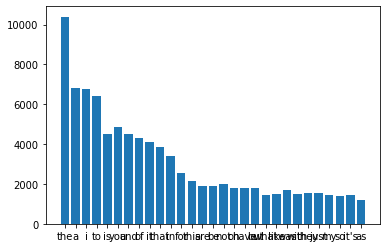

In [16]:
import matplotlib.pyplot as plt

# A sequence from 0 to 29 is created
list_c = [i for i in range(30)]

# The string value of the 30 most used tokens are retrieved
example_seq = input_tokenizer.sequences_to_texts([list_c])[0]
print(example_seq)

# Turns the example_seq string into a list of words
x = example_seq.split()

# The 30 most popular words are plotted based on their occurrence
plt.bar(x, list(subset_dict.values())[:len(x)], align = 'center')
plt.show()

### Word embeddings

This is where our work for the second milestone starts. We relied heavily on [this](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/) guide on stackabuse. Although we made several modifications to get it to work with our dataset.

The following section embeds the words recognized by the model in a vector with 100 dimensions.

In [17]:
# import statements
from numpy import array
from numpy import asarray
from numpy import zeros

In [6]:
# we used the pretrained vector embedding model GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip glove.6B.zip

--2020-12-10 13:20:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-10 13:20:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-10 13:20:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
# unzip the downloaded file
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
#set embedding size
EMBEDDING_SIZE = 100

In [19]:
# the embedding dictionary is a dictionary with the key being a word,
# and the value being the corresponding 100d vector
embeddings_dictionary = dict()

# open the file containing the 100d vectors
glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

# iterate over the lines in the file
for line in glove_file:
    records = line.split()  # split along whitespaces
    word = records[0]       # the word itself is the first element of the list
    # the vector representation is the rest of the elements
    vector_dimensions = asarray(records[1:], dtype='float32')  
    embeddings_dictionary[word] = vector_dimensions  # insert word: vector representation into dictionary
glove_file.close()  # close GloVe file

In [20]:
# create the embedding matrix

# limit the number of words understood by the model to MAX_NUM_WORDS
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# create embedding matrix filled with zeroes
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

# iterate over the first MAX_NUM_WORDS collected by the tokenizer
for word, index in list(word2idx_inputs.items())[:num_words-1]:
  # get embedding vector corresponding to the given word
  embedding_vector = embeddings_dictionary.get(word)
  # if embedding vector exists, the insert into relevant column of the mbedding matrix
  # null vector by default
  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [21]:
# some testing
index = 4997

In [22]:
# print last word
print(list(word2idx_inputs.items())[index])

('superpowers', 4998)


In [23]:
# print embedding of word from the embedding dictionary
print(embeddings_dictionary[list(word2idx_inputs.items())[index][0]])

[ 8.2561e-01  7.0368e-01  1.0856e+00  1.8640e-01 -3.3048e-01 -1.1595e+00
 -4.0692e-02 -1.5319e-01  1.8652e-01 -3.2869e-01 -7.1025e-02 -4.5381e-01
  4.2302e-01  3.7044e-01  1.1495e-01 -2.8965e-01  3.6515e-01  4.5981e-01
 -1.7285e-01 -8.6656e-01  3.5760e-01  1.1741e-01  1.0402e-01 -1.6487e-01
  8.5793e-01  4.4120e-02 -3.1421e-01  4.0868e-01 -1.0667e-02 -9.8774e-02
  5.4666e-01 -1.0250e-01 -6.8991e-01 -6.8826e-01  3.0186e-01 -1.6146e-02
  1.5912e-01 -5.5968e-01 -5.7463e-01  1.5893e-02 -4.1537e-01  6.1719e-01
 -1.7870e-01 -4.5237e-01  1.6250e-01 -3.7825e-02  9.4251e-01  4.8348e-01
  2.3142e-01  2.6951e-01 -6.6098e-01  3.8090e-01 -4.2468e-01  7.1296e-01
  1.1183e+00  3.7083e-02  4.7085e-01 -4.0589e-01 -6.6160e-01  9.4728e-02
  1.2168e-01  5.2807e-01 -3.9111e-01  1.3211e-01 -5.3060e-02  2.4917e-01
 -2.5457e-01  4.3781e-04  1.5508e-01  2.7041e-01  5.7762e-02 -3.7124e-01
 -1.8106e-01  5.6205e-02 -8.4670e-01  9.5469e-03 -1.7227e-01 -7.2889e-01
 -5.0670e-01  2.1736e-01  3.8822e-01  1.4572e-02 -2

In [24]:
# print embedding of word from the embedding matrix
print(embedding_matrix[list(word2idx_inputs.items())[index][1]])

[ 8.25609982e-01  7.03679979e-01  1.08560002e+00  1.86399996e-01
 -3.30480009e-01 -1.15950000e+00 -4.06920016e-02 -1.53190002e-01
  1.86519995e-01 -3.28689992e-01 -7.10249990e-02 -4.53810006e-01
  4.23020005e-01  3.70440006e-01  1.14950001e-01 -2.89649993e-01
  3.65150005e-01  4.59809989e-01 -1.72849998e-01 -8.66559982e-01
  3.57600003e-01  1.17409997e-01  1.04020000e-01 -1.64869994e-01
  8.57930005e-01  4.41199988e-02 -3.14209998e-01  4.08679992e-01
 -1.06670000e-02 -9.87740010e-02  5.46660006e-01 -1.02499999e-01
 -6.89909995e-01 -6.88260019e-01  3.01860005e-01 -1.61460005e-02
  1.59119993e-01 -5.59679985e-01 -5.74630022e-01  1.58929992e-02
 -4.15369987e-01  6.17190003e-01 -1.78700000e-01 -4.52369988e-01
  1.62499994e-01 -3.78249995e-02  9.42510009e-01  4.83480006e-01
  2.31419995e-01  2.69510001e-01 -6.60979986e-01  3.80899996e-01
 -4.24679995e-01  7.12960005e-01  1.11829996e+00  3.70829999e-02
  4.70849991e-01 -4.05889988e-01 -6.61599994e-01  9.47280005e-02
  1.21679999e-01  5.28069

### Model structure
This section builds the model and trains it based on the data compiled in the previous sections.

In [72]:
# Macros are defined for training.
BATCH_SIZE = 64
EPOCHS = 20

In [73]:
# import statements
import numpy as np
from tensorflow.keras.layers import Embedding

In [74]:
# create embedding layer from embedding matrix
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [151]:
print(type(embedding_layer))

<class 'tensorflow.python.keras.layers.embeddings.Embedding'>


In [75]:
# get input sentences
input_sentences = xy_data_df['input']

In [76]:
# pad output sequences to the same length,
# namely to the maximum length of the output sequences
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [294]:
print(type(decoder_output_sequences))
print(decoder_output_sequences.shape)
print(decoder_output_sequences[0])
id_list = list(word2idx_outputs)

print(xy_data_df['output'][0])

<class 'numpy.ndarray'>
(10000, 44)
[  35   24   20   15   31  527    7   12  247    3   20 4190   12    3
  455   10    3 1195 4191  127   10    3   55    6    3  161   10    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
No, they have not. What gave you that idea? The have ruled that the rights of the mother outweigh those of the unborn up to the point of viability. <eos>


In [78]:
from tensorflow.keras.utils import Sequence
import math

In [295]:
class LSTM_train_data_generator(Sequence):

    def __init__(self, x_set_1, x_set_2, y_set, batch_size, max_out_len, num_words):
        self.x_1, self.x_2, self.y = x_set_1, x_set_2, y_set
        self.batch_size = batch_size
        self.max_out_len = max_out_len
        self.num_words = num_words
        self.whole_batch = batch_size
        print(self.whole_batch)
        assert len(self.x_1) == len(self.x_2)
        assert len(self.x_2) == len(self.y)

    def __len__(self):
        return math.floor(len(self.x_1) / self.whole_batch)

    def __getitem__(self, idx):
        batch_x_1 = self.x_1[idx*self.whole_batch : (idx + 1)*self.whole_batch]
        batch_x_2 = self.x_2[idx*self.whole_batch : (idx + 1)*self.whole_batch]
        batch_y = self.y[idx*self.whole_batch : (idx + 1)*self.whole_batch]

        train_batch_x_1 = batch_x_1[:self.batch_size]
        train_batch_x_2 = batch_x_2[:self.batch_size]
        train_batch_y = batch_y[:self.batch_size]

        train_decoder_targets_one_hot = np.zeros((
                self.batch_size,
                self.max_out_len,
                self.num_words),dtype='float32')
        
        # fill the previously created null hypermatrix with one hot columns in the following fashion:
        # Insert value 1 into every r-th row of every c-th column of every m-th matrix where;
        # m is the index of the sentence in decoder_output_sequences: 1-st sentence -> m = 0, n-th sentence -> m = n-1
        # c is the place of the word in the sentence: 1-st word in sentence -> c = 0, n-th word in sentence -> c = n-1
        # r is the value given to the word by th output tokenizer: '<eos>' -> r = 1, 'not' -> r = 15
        
        for m, sequence in enumerate(train_batch_y):
          for c, r in enumerate(sequence):
              train_decoder_targets_one_hot[m, c, r] = 1        

        return [train_batch_x_1, train_batch_x_2], train_decoder_targets_one_hot

In [288]:
class LSTM_val_data_generator(Sequence):

    def __init__(self, x_set_1, x_set_2, y_set, batch_size, max_out_len, num_words):
        self.x_1, self.x_2, self.y = x_set_1, x_set_2, y_set
        self.batch_size = batch_size
        self.max_out_len = max_out_len
        self.num_words = num_words
        self.whole_batch = 2*batch_size
        print(self.whole_batch)
        assert len(self.x_1) == len(self.x_2)
        assert len(self.x_2) == len(self.y)

    def __len__(self):
        return math.floor(len(self.x_1) / self.whole_batch)

    def __getitem__(self, idx):
        batch_x_1 = self.x_1[idx*self.whole_batch : (idx + 1)*self.whole_batch]
        batch_x_2 = self.x_2[idx*self.whole_batch : (idx + 1)*self.whole_batch]
        batch_y = self.y[idx*self.whole_batch : (idx + 1)*self.whole_batch]
        
        val_batch_x_1 = batch_x_1[self.batch_size:]
        val_batch_x_2 = batch_x_2[self.batch_size:]
        val_batch_y = batch_y[self.batch_size:]

        val_decoder_targets_one_hot = np.zeros((
          self.batch_size,
          self.max_out_len,
          self.num_words),dtype='float32')
        
        for m, sequence in enumerate(val_batch_y):
          for c, r in enumerate(sequence):
              val_decoder_targets_one_hot[m, c, r] = 1

        return [val_batch_x_1, val_batch_x_2], val_decoder_targets_one_hot

In [272]:
# set number of LSTM nodes
LSTM_NODES = 256

In [273]:
# import statements
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras import Model

In [274]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))

In [275]:
# The encoder of the model is defined.
# The input of the encoder are the sentences and the output is
# the hidden state and cell state of the LSTM. 

x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [276]:
# The decoder is defined.
# The input of the decoder are the hidden state and cell state of the
# encoder and the input sentence.
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [277]:
# The output of the decoder is given to a dense layer to predict
# the decoder output.
decoder_dense = Dense(num_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [278]:
# The model is connected and compiled. There are two inputs: the
# encoder and the decoder input.
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'val_accuracy']
)

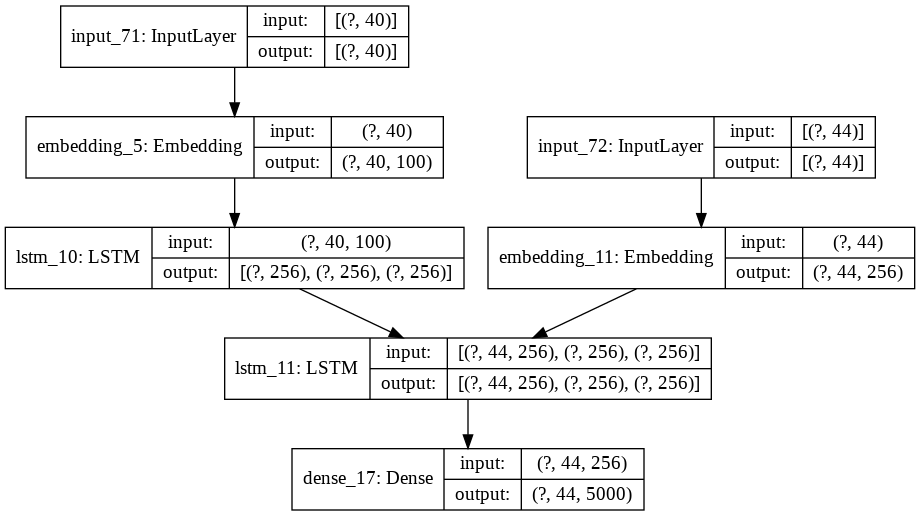

In [279]:
# The structure of the model is plotted.
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [296]:
# Input shapes are printed.
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)

(10000, 40)
(10000, 44)


In [289]:
train_data = LSTM_train_data_generator(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, BATCH_SIZE, max_out_len, num_words)
val_data = LSTM_val_data_generator(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, BATCH_SIZE, max_out_len, num_words)
b = val_data[0]
print(b[0][0].shape)
print(encoder_input_sequences.shape)
print(b[0][0][0])
print(encoder_input_sequences[0])

print(b[0][1].shape)
print(decoder_input_sequences.shape)
print(b[0][1][0])
print(decoder_input_sequences[0])

print(b[1].shape)
print(decoder_output_sequences.shape)
print(b[1][0][1][24])
print(decoder_output_sequences[0])

128
128
(64, 40)
(10000, 40)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  105    6  211    9 1399  242 2626  898  117
  113   58    8    1 3084    7    1  537  646    8 3731  130]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1517  131   89  339 1306   17 4687
    2 2615   29  206    8    2  807  339   77  114  181 3717]
(64, 44)
(10000, 44)
[  2 226   9   5 502 131   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
[   2   35   24   20   15   31  527    7   12  247    3   20 4190   12
    3  455   10    3 1195 4191  127   10    3   55    6    3  161   10
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
(64, 44, 5000)
(10000, 44)
0.0
[  35   24   20   15   31  527    7   12  247    3   20 4190   12    3
  455   10    3 1195 4191  127   10

In [292]:
# The model is trained.
r = model.fit(
    x=train_data,
    
    batch_size=BATCH_SIZE,
    epochs=20
    # validation_split=0.2,
)

TypeError: ignored

In [ ]:
# The model is trained.
r = model.fit(
    x=a,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # validation_split=0.2,
)

Epoch 1/20
156/156 [==============================] - 12s 75ms/step - loss: 1.8340 - accuracy: 0.7254
Epoch 2/20
156/156 [==============================] - 12s 76ms/step - loss: 1.7728 - accuracy: 0.7310
Epoch 3/20
156/156 [==============================] - 12s 76ms/step - loss: 1.7237 - accuracy: 0.7356
Epoch 4/20
156/156 [==============================] - 12s 76ms/step - loss: 1.6878 - accuracy: 0.7382
Epoch 5/20
156/156 [==============================] - 12s 76ms/step - loss: 1.6566 - accuracy: 0.7401
Epoch 6/20
156/156 [==============================] - 12s 75ms/step - loss: 1.6286 - accuracy: 0.7416
Epoch 7/20
156/156 [==============================] - 12s 76ms/step - loss: 1.6023 - accuracy: 0.7433
Epoch 8/20
156/156 [==============================] - 12s 75ms/step - loss: 1.5767 - accuracy: 0.7448
Epoch 9/20
156/156 [==============================] - 12s 77ms/step - loss: 1.5519 - accuracy: 0.7463
Epoch 10/20
156/156 [==============================] - 12s 77ms/step - loss: 1.526

In [ ]:
# The model is trained.
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/20
125/125 [==============================] - 11s 90ms/step - loss: 2.2361 - accuracy: 0.7057 - val_loss: 1.8554 - val_accuracy: 0.7257
Epoch 2/20
125/125 [==============================] - 11s 85ms/step - loss: 1.8481 - accuracy: 0.7246 - val_loss: 1.8161 - val_accuracy: 0.7279
Epoch 3/20
125/125 [==============================] - 11s 84ms/step - loss: 1.7931 - accuracy: 0.7282 - val_loss: 1.7757 - val_accuracy: 0.7328
Epoch 4/20
125/125 [==============================] - 10s 84ms/step - loss: 1.7442 - accuracy: 0.7332 - val_loss: 1.7476 - val_accuracy: 0.7358
Epoch 5/20
125/125 [==============================] - 11s 84ms/step - loss: 1.7053 - accuracy: 0.7360 - val_loss: 1.7268 - val_accuracy: 0.7380
Epoch 6/20
125/125 [==============================] - 10s 84ms/step - loss: 1.6725 - accuracy: 0.7381 - val_loss: 1.7146 - val_accuracy: 0.7392
Epoch 7/20
125/125 [==============================] - 10s 83ms/step - loss: 1.6429 - accuracy: 0.7399 - val_loss: 1.7078 - val_accuracy:

### Modifying the model for predictions
In the following section the model is changed for predictions. The output sentence is predicted word by word. At every step the an output word will be predicted based on the results of the previous prediction

In [118]:
# Encoder model is the same as last time.
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [119]:
# Input layers receive the hidden and cell states of the decoder. 
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [120]:
# At each step the decoder will receive one word.
# Decoder embedding layer is modified.
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [121]:
# Placeholder for decoder outputs
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [122]:
# The decoder output is passed through a dense layer. 
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [123]:
# Decoder model definition
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

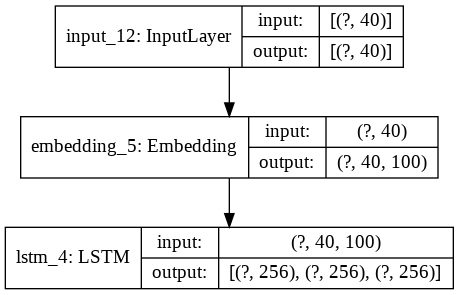

In [124]:
# Plot the decoder LSTM
from keras.utils import plot_model
plot_model(encoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

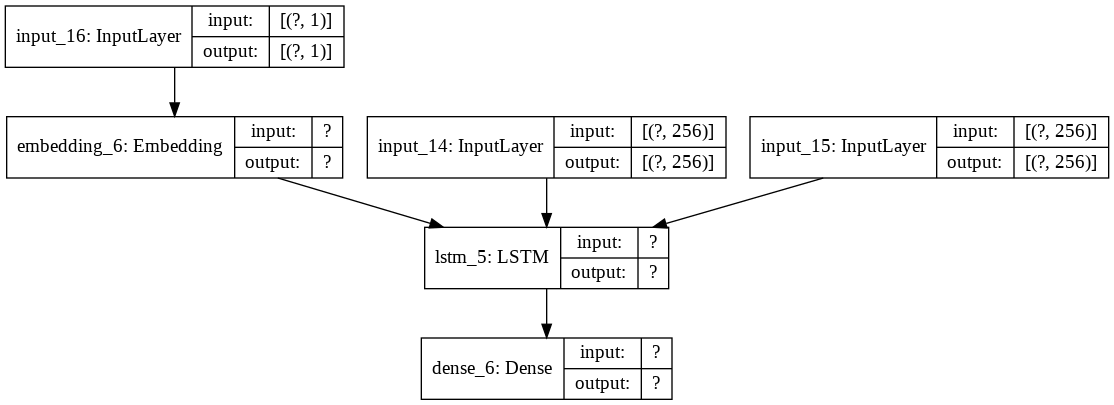

In [125]:
# Plot the decoder LSTM
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [126]:
# Dictionaries for input and ouput
# They help converting the integers back to words.
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [128]:
# Predicts the answer for an input sentence.
def answer_sentence(input_seq):
    # The encoder model predicts the hidden and cell state.
    states_value = encoder_model.predict(input_seq)
    # Target stores the integer representation of <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    # Eos stores the integer representation of <eos>
    eos = word2idx_outputs['<eos>']
    # Stores the response
    output_sentence = []

    # Every iteration a word of the output sentence is predicted.
    for _ in range(max_out_len):
        # The output, the hidden and cell states are predicted.
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # The most probable word is selected.
        idx = np.argmax(output_tokens[0, 0, :])
        # If the word is <eos>, the loop ends.
        if eos == idx:
            break

        word = ''
        # The token is converted to a word and added to the output sentence
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        # Target_eq and states_value are refreshed.
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

### Save model
This section saves and download the model. The saved model was too large for github, it is available as a [google drive](https://drive.google.com/file/d/1mpYifGZ_TLrer6ZgRtNKO25xSuMOPi1u/view?usp=sharing) link.

In [ ]:
# save model
model.save('model_2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_2/assets


In [ ]:
# zip saved model
!zip -r model_2.zip model_2

  adding: model_2/ (stored 0%)
  adding: model_2/assets/ (stored 0%)
  adding: model_2/saved_model.pb (deflated 90%)
  adding: model_2/variables/ (stored 0%)
  adding: model_2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_2/variables/variables.index (deflated 64%)


In [ ]:
# download saved model
from google.colab import files
files.download('model_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# zip saved model
!zip -r output.zip output


  adding: output/ (stored 0%)
  adding: output/Chatbot_hyperband/ (stored 0%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/ (stored 0%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/checkpoints/ (stored 0%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/checkpoints/epoch_0/ (stored 0%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/checkpoints/epoch_0/checkpoint.index (deflated 69%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 15%)
  adding: output/Chatbot_hyperband/trial_9c971e2c3189ac58d226c86be9e7137b/trial.json (deflated 62%)
  adding: output/Chatbot_hyperband/trial_a331379b7aa8a2df7f5b5e190b0679fa/ (stored 0%)
  adding: output/Chatbot_hyperband/trial_a331379b7aa8a2d

In [ ]:
from google.colab import files
files.download('output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Further training and hyperparameter optimization

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 320.4MB 55kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


     |████████████████████████████████| 320.4MB 39kB/s 


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 5.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=0dbef53d275afebb8434f0458d27c7728cf9bf068f92c0efd28a466d133b4a6a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=b7830efbbabe30dbd742b49c95952f6140ea8710d86b458aa6c15043c935bbc3
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [36]:
# import statements
import tensorflow as tf
from tensorflow import keras
import numpy as np
# import statements
import numpy as np
from tensorflow.keras.layers import Embedding
# import statements
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Bidirectional
from tensorflow.keras import Model

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1uh5JGW-91Pp-DK1x-Aryd3LJ2zE5lIlF',
                                    dest_path='./model_1.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
reconstructed_model = keras.models.load_model("model_1")

In [ ]:
def build_model(hp):
    # set number of LSTM nodes
    LSTM_NODES = hp.Int('LSTM_var', min_value=256,max_value=512,step=256)
    # The encoder of the model is defined.
    # The input of the encoder are the sentences and the output is
    # the hidden state and cell state of the LSTM.

    embedding_layer = Embedding(5000, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=40)
    encoder_inputs_placeholder = Input(shape=(40,))
    x = embedding_layer(encoder_inputs_placeholder)

    # lstm_1_var = hp.Choice('lstm_1_var', values = [LSTM(LSTM_NODES, return_state=True), Bidirectional(LSTM(LSTM_NODES, return_state=True))])

    # if hp.Boolean('lstm_1_bool'):
    encoder = LSTM(LSTM_NODES, return_state=True)
    # else:
    #   encoder = Bidirectional(LSTM(LSTM_NODES, return_state=True))

    encoder_outputs, h, c = encoder(x)
    encoder_states = [h, c]

    # The decoder is defined.
    # The input of the decoder are the hidden state and cell state of the
    # encoder and the input sentence.
    decoder_inputs_placeholder = Input(shape=(44,))

    decoder_embedding = Embedding(5000, LSTM_NODES)
    decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

    # lstm_2_var = hp.Choice('lstm_2_var', values = [LSTM(LSTM_NODES, return_sequences=True, return_state=True), Bidirectional(LSTM(LSTM_NODES, return_sequences=True, return_state=True))])

    # if hp.Boolean('lstm_2_bool'):
    decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
    # else:
    #   decoder_lstm = Bidirectional(LSTM(LSTM_NODES, return_sequences=True, return_state=True))

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

    activation_var = 'relu' # hp.Choice('activation_var', values = ['relu', 'sigmoid'])
    nodes_var = hp.Int('nodes_var', min_value=4500,max_value=5500, step=1000)
    for i in range(hp.Int('n_layers', 0, 3)):  # adding variation of layers.
      new_dense_layer = Dense(nodes_var, activation=activation_var)
      decoder_outputs = new_dense_layer(decoder_outputs)
      new_dropout_layer = Dropout(0.2)
      decoder_outputs = new_dropout_layer(decoder_outputs)

    mid_layer = Dense(nodes_var, activation=activation_var)
    decoder_outputs_2 = mid_layer(decoder_outputs)

    # The output of the decoder is given to a dense layer to predict
    # the decoder output.
    decoder_dense = Dense(5000, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # The model is connected and compiled. There are two inputs: the
    # encoder and the decoder input.
    model = Model([encoder_inputs_placeholder,
      decoder_inputs_placeholder], decoder_outputs)

    
    model.compile(
        optimizer=hp.Choice('optimizer_var', values = ['rmsprop','sgd','adam']),#,'nadam','adagard']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
!rm /content/output -r


In [ ]:
tuner = None

In [ ]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective='accuracy',
    factor=3,
    max_epochs=10,
    directory='output',
    project_name='Chatbot_hyperband')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
LSTM_var (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 256, 'sampling': None}
nodes_var (Int)
{'default': None, 'conditions': [], 'min_value': 4500, 'max_value': 5500, 'step': 1000, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
optimizer_var (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'sgd', 'adam'], 'ordered': False}


In [ ]:
tuner.search(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
nodes_var         |5500              |?                 
n_layers          |1                 |?                 
optimizer_var     |adam              |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2
125/125 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 2.5568e-05

In [ ]:
tuner.search(
    x=a,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Trial 31 Complete [00h 09m 54s]
accuracy: 0.7504324913024902

Best accuracy So Far: 0.7559504508972168
Total elapsed time: 01h 25m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models(num_models=3)

In [ ]:
tuner.results_summary()

Results summary
Results in output/Chatbot_hyperband
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_var: 512
nodes_var: 4500
n_layers: 3
optimizer_var: adam
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7559504508972168
Trial summary
Hyperparameters:
LSTM_var: 256
nodes_var: 4500
n_layers: 3
optimizer_var: adam
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7504324913024902
Trial summary
Hyperparameters:
LSTM_var: 512
nodes_var: 4500
n_layers: 1
optimizer_var: rmsprop
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 3520464fef6e74138cc4daee1b31c1df
Score: 0.747215986251831
Trial summary
Hyperparameters:
LSTM_var: 512
nodes_var: 5500
n_layers: 2
optimizer_var: rmsprop
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 51c9d181622148998413cbb6406504ad
Score: 0.7462644577026367
Trial summary


### Training the optimized model

In [200]:
# Macros are defined for training.
BATCH_SIZE = 64
EPOCHS = 30
MAX_NUM_WORDS = 5000
LSTM_NODES = 512
N_LAYERS = 3
NODES_VAR = 4500
OPTIMIZER_VAR = 'adam'

In [201]:
def build_model():
    # set number of LSTM nodes
    LSTM_NODES = 512
    # The encoder of the model is defined.
    # The input of the encoder are the sentences and the output is
    # the hidden state and cell state of the LSTM.

    embedding_layer = Embedding(MAX_NUM_WORDS, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=40)
    encoder_inputs_placeholder = Input(shape=(40,))
    x = embedding_layer(encoder_inputs_placeholder)

    # lstm_1_var = hp.Choice('lstm_1_var', values = [LSTM(LSTM_NODES, return_state=True), Bidirectional(LSTM(LSTM_NODES, return_state=True))])

    # if hp.Boolean('lstm_1_bool'):
    encoder = LSTM(LSTM_NODES, return_state=True)
    # else:
    #   encoder = Bidirectional(LSTM(LSTM_NODES, return_state=True))

    encoder_outputs, h, c = encoder(x)
    encoder_states = [h, c]

    # The decoder is defined.
    # The input of the decoder are the hidden state and cell state of the
    # encoder and the input sentence.
    decoder_inputs_placeholder = Input(shape=(44,))

    decoder_embedding = Embedding(MAX_NUM_WORDS, LSTM_NODES)
    decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

    # lstm_2_var = hp.Choice('lstm_2_var', values = [LSTM(LSTM_NODES, return_sequences=True, return_state=True), Bidirectional(LSTM(LSTM_NODES, return_sequences=True, return_state=True))])

    # if hp.Boolean('lstm_2_bool'):
    decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
    # else:
    #   decoder_lstm = Bidirectional(LSTM(LSTM_NODES, return_sequences=True, return_state=True))

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

    activation_var = 'relu'
    nodes_var = NODES_VAR
    for i in range(N_LAYERS):  # adding variation of layers.
      new_dense_layer = Dense(nodes_var, activation=activation_var)
      decoder_outputs = new_dense_layer(decoder_outputs)
      new_dropout_layer = Dropout(0.2)
      decoder_outputs = new_dropout_layer(decoder_outputs)

    mid_layer = Dense(nodes_var, activation=activation_var)
    decoder_outputs_2 = mid_layer(decoder_outputs)

    # The output of the decoder is given to a dense layer to predict
    # the decoder output.
    decoder_dense = Dense(5000, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # The model is connected and compiled. There are two inputs: the
    # encoder and the decoder input.
    model = Model([encoder_inputs_placeholder,
      decoder_inputs_placeholder], decoder_outputs)

    
    model.compile(
        optimizer=OPTIMIZER_VAR,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [204]:
my_data = LSTM_train_data_generator(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, BATCH_SIZE, max_out_len, num_words)
my_model = build_model()

64


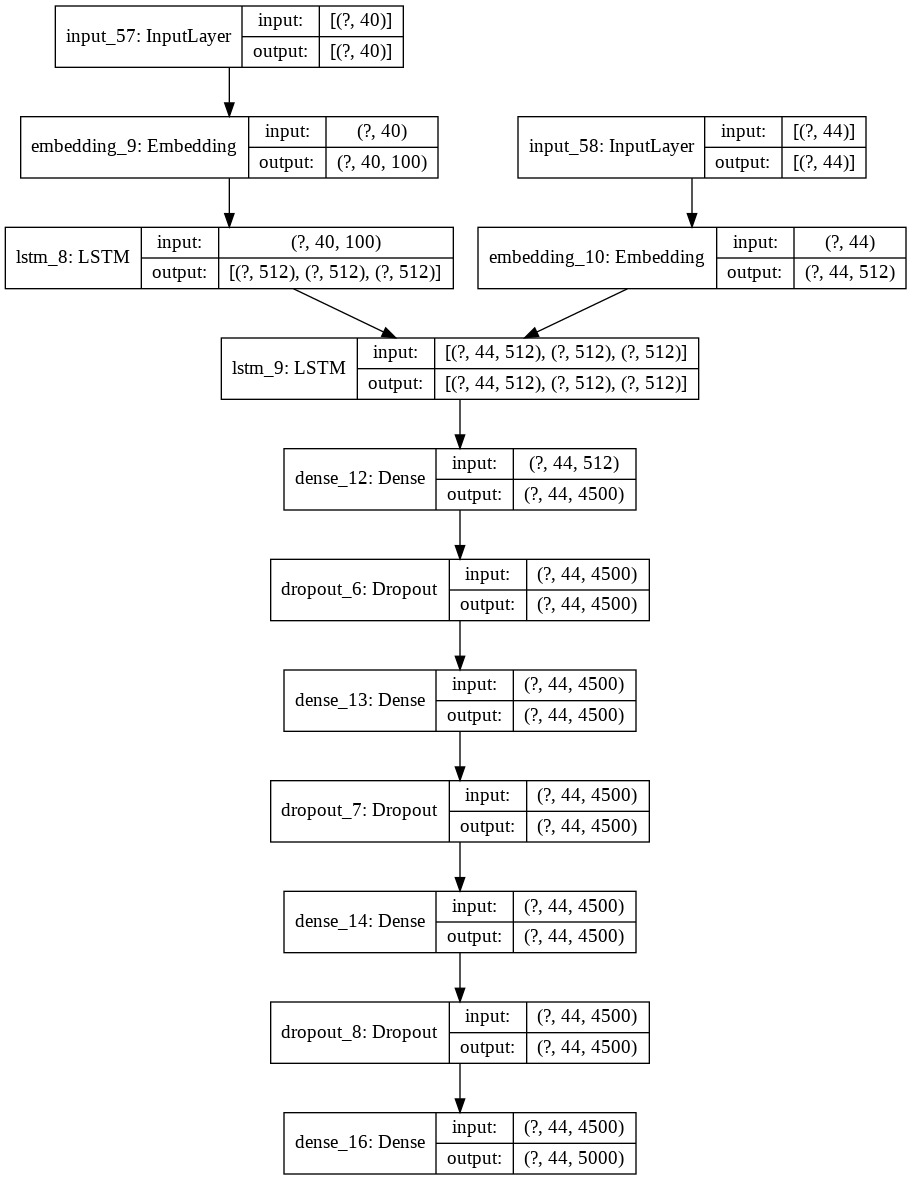

In [205]:
from keras.utils import plot_model
plot_model(my_model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [232]:
my_model.fit(
    x=my_data,
    batch_size=BATCH_SIZE,
    epochs=20 #EPOCHS
)

Epoch 1/20
156/156 [==============================] - 69s 441ms/step - loss: 0.1549 - accuracy: 0.9555
Epoch 2/20
156/156 [==============================] - 70s 446ms/step - loss: 0.1450 - accuracy: 0.9584
Epoch 3/20
156/156 [==============================] - 70s 446ms/step - loss: 0.1334 - accuracy: 0.9618
Epoch 4/20
156/156 [==============================] - 70s 448ms/step - loss: 0.1269 - accuracy: 0.9634
Epoch 5/20
156/156 [==============================] - 70s 447ms/step - loss: 0.1195 - accuracy: 0.9654
Epoch 6/20
156/156 [==============================] - 70s 446ms/step - loss: 0.1169 - accuracy: 0.9665
Epoch 7/20
156/156 [==============================] - 70s 448ms/step - loss: 0.1099 - accuracy: 0.9683
Epoch 8/20
156/156 [==============================] - 70s 448ms/step - loss: 0.1023 - accuracy: 0.9702
Epoch 9/20
156/156 [==============================] - 70s 446ms/step - loss: 0.0995 - accuracy: 0.9711
Epoch 10/20
156/156 [==============================] - 69s 445ms/step - l

In [234]:
# save model
my_model.save('model_4')

INFO:tensorflow:Assets written to: model_4/assets


In [255]:
!rm model_4 -r


In [258]:
!unzip model_4.zip

Archive:  model_4.zip
   creating: model_4/
   creating: model_4/assets/
  inflating: model_4/saved_model.pb  
   creating: model_4/variables/
  inflating: model_4/variables/variables.data-00000-of-00001  
  inflating: model_4/variables/variables.index  


In [208]:
# zip saved model
!zip -r model_4.zip model_4

  adding: model_4/ (stored 0%)
  adding: model_4/assets/ (stored 0%)
  adding: model_4/saved_model.pb (deflated 90%)
  adding: model_4/variables/ (stored 0%)
  adding: model_4/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: model_4/variables/variables.index (deflated 69%)


In [259]:
from tensorflow.keras.models import load_model
t = load_model('model_4', compile=False)

In [236]:
def create_encoder_decoder_models(from_model):
  encoder_inputs_placeholder = Input(shape=(40,))

  embedding_layer = from_model.get_layer('embedding_9')
  x = embedding_layer(encoder_inputs_placeholder)

  encoder = from_model.get_layer('lstm_8')

  encoder_outputs, h, c = encoder(x)
  encoder_states = [h, c]

  encoder_model = Model(encoder_inputs_placeholder, encoder_states)


  ##################

  # decoder_state_input_h = None
  # decoder_state_input_c = None
  # decoder_states_inputs = None

  # decoder_inputs_single = None
  # decoder_embedding = None
  # decoder_inputs_single_x = None

  # decoder_lstm = None
  # decoder_outputs, h, c = None, None, None

  # decoder_states = None

  # opt_dense_0 = None
  # opt_dense_1 = None
  # opt_dense_2 = None

  # decoder_outputs = None
  # decoder_outputs = None
  # decoder_outputs = None

  # decoder_dense = None
  # decoder_outputs = None

  # decoder_model = None


  decoder_state_input_h = Input(shape=(512,))
  decoder_state_input_c = Input(shape=(512,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_inputs_single = Input(shape=(1,))
  decoder_embedding = from_model.get_layer('embedding_10')
  decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

  decoder_lstm = from_model.get_layer('lstm_9')
  decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

  decoder_states = [h, c]

  opt_dense_0 = from_model.get_layer('dense_12')
  opt_dense_1 = from_model.get_layer('dense_13')
  opt_dense_2 = from_model.get_layer('dense_14')

  decoder_outputs = opt_dense_0(decoder_outputs)
  decoder_outputs = opt_dense_1(decoder_outputs)
  decoder_outputs = opt_dense_2(decoder_outputs)

  decoder_dense = from_model.get_layer('dense_16')
  decoder_outputs = decoder_dense(decoder_outputs)

  decoder_model = Model(
      [decoder_inputs_single] + decoder_states_inputs,
      [decoder_outputs] + decoder_states
  )

  
  return encoder_model, decoder_model



In [260]:
test_model_enc, test_model_dec = create_encoder_decoder_models(t)

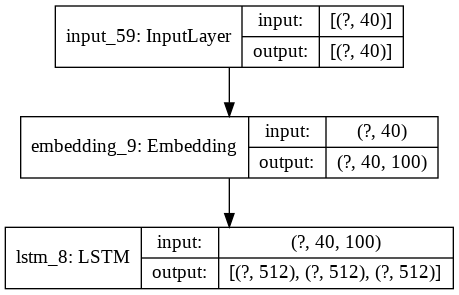

In [212]:
from keras.utils import plot_model
plot_model(test_model_enc, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

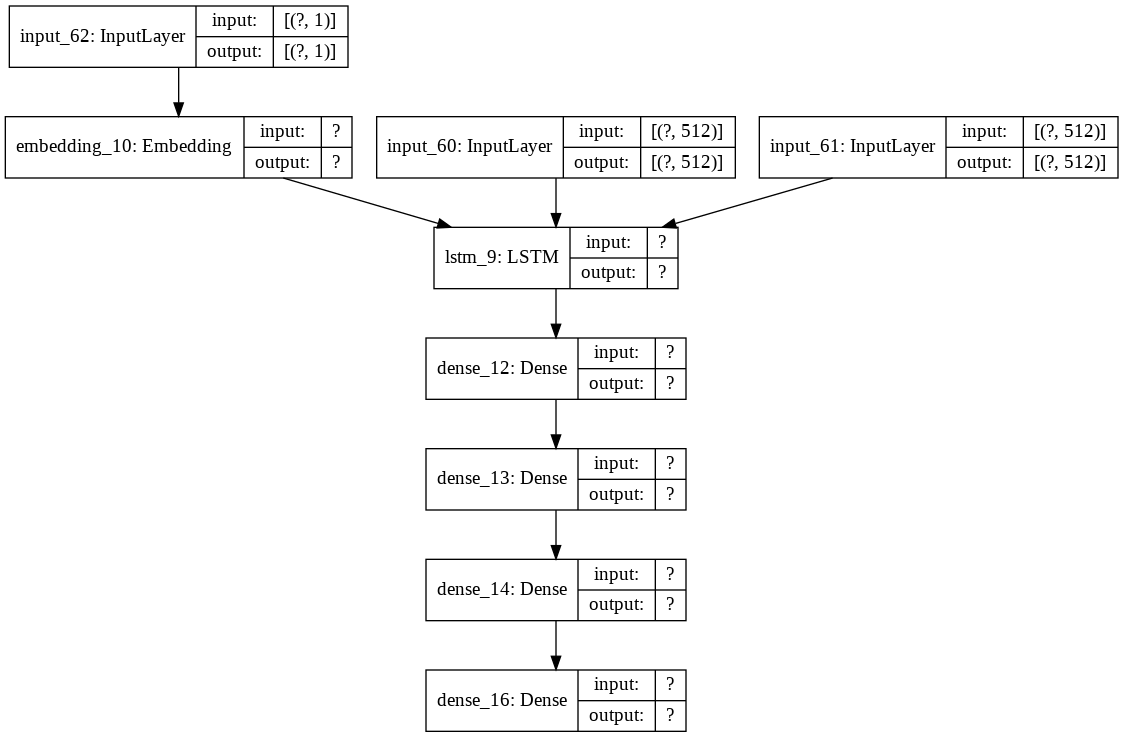

In [213]:
from keras.utils import plot_model
plot_model(test_model_dec, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [261]:
# Dictionaries for input and ouput
# They help converting the integers back to words.
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [262]:
# Predicts the answer for an input sentence.
def answer_sentence_1(input_seq):
    # The encoder model predicts the hidden and cell state.
    states_value = test_model_enc.predict(input_seq)
    # Target stores the integer representation of <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    # Eos stores the integer representation of <eos>
    eos = word2idx_outputs['<eos>']
    # Stores the response
    output_sentence = []

    # Every iteration a word of the output sentence is predicted.
    for _ in range(max_out_len):
        # The output, the hidden and cell states are predicted.
        output_tokens, h, c = test_model_dec.predict([target_seq] + states_value)
        # The most probable word is selected.
        idx = np.argmax(output_tokens[0, 0, :])
        # If the word is <eos>, the loop ends.
        if eos == idx:
            break

        word = ''
        # The token is converted to a word and added to the output sentence
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        # Target_eq and states_value are refreshed.
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [268]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print(input_seq)
translation = answer_sentence_1(input_seq)
print('-')
print('Input: ', input_sentences[i])
print('Response: ', translation)
print("Actual response: ",xy_data_df['output_input'][i][6:])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 4248  511    7   14  221   70    2 2519]]
-
Input:  Nerdist, hardcore history, and radiolab are best, by a wide margin.
Response:  the best episode by far was the one with totally worth listening to what's your
Actual response:  The best Nerdist episode BY FAR was the one with Alex Trebek. Totally worth listening to. What's your fave?


In [245]:
print(xy_data_df['input'][i])
print()
print(xy_data_df['output'][i])
print()
print(xy_data_df['output_input'][i])

What's weird, and frankly INSANE, about this is that it's current news.  That this is happening currently in a society around right now completely blows my mind.  I feel so removed from it all

It really highlights the dangers of having such an insane megalomaniac killer in charge of a nation of people.  Image what worldwide horrors he might cause if he is able too.   <eos>

<sos> It really highlights the dangers of having such an insane megalomaniac killer in charge of a nation of people.  Image what worldwide horrors he might cause if he is able too.  


In [269]:
for i in range(10):
  print('-')
  my_inp = input()

  tokenized_input = input_tokenizer.texts_to_sequences([my_inp])
  input_seq = pad_sequences(tokenized_input, maxlen=max_input_len)
  translation = answer_sentence_1(input_seq)
  print('Response:', translation)

-
Hitler did nothing wrong
Response: the at waste of us you're going to be a rape victim
-


KeyboardInterrupt: ignored

### Evaluation
Evaluate a few input sentences

In [130]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = answer_sentence_1(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: The description sounds more like Bioshock to me, though.
Response: i don't have to be a lot of the


### Conclusion

This model still has a way to go, but with a single training cycle the results were positive. The future goal is to create a better bot via training and trying to make a better model in general. We expect to arrive at a somewhat sensible model (as sensible as a model trained on reddit comments can be).
The desired result would be a model which can react to inputs properly (in a way that makes sense in the given context). 

We will try to mitigate some of the problems we found in the answer the bot gave, such as words repeating and the bot giving an irrelevant answer. This can be achieved by using more data, having more training cycles, filtering the training data better (this is a hard thing to do, since there are so many comments that this needs to be automated, and creating an algorithm which can filter good data from bad data is hard) and trying different models.

The end result won't be quantifiable by a computer, we need to label good and bad outcomes.